# Task: Model the dynamics of gender in intro CS


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries


import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplt
import seaborn as sns
import tools
import inputData
   
plt.style.use('ggplot')

## Exploring the Data

Let's go ahead and read in the student dataset first.


In [3]:
dataset = inputData.preprocess()

In [4]:
dataset = dataset.query('gender == "Female" or gender == "Male"')
dataset = dataset.reset_index(drop=True)


print '{:d}{:20}{:d}{:20}'.format(len(dataset.query('gender == "Male"')), ' male students, and ',
                                  len(dataset.query('gender == "Female"')),
                                  ' female students consented to participate in this study')
                        

494 male students, and 388 female students consented to participate in this study


#### Drop the columns that aren't needed for the model

In [5]:
columnsNotNeeded = ['timestamp', 'consent','name', 'name_1', 'name_2', 
                    'morecs','snap_python','hiphop_d1','hiphop_d2','song_ct', 'major'] 
dataset.drop(columnsNotNeeded, axis=1, inplace=True)
                   

### Preprocess feature columns

There are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `prcs_2`. These can be reasonably converted into `1`/`0` (binary) values. For the columns whose values are `Nan`, I am going to convert these to `0`. 


**Note**: These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            # e.g. 'reason' => 'reason_class_Interested' , 'reason_class_Other'
            col_data = pd.get_dummies(col_data, prefix=col)

        outX = outX.join(col_data)  # collect column(s) in output dataframe
        outX.fillna(0, inplace=True) # make sure all NaN <missing> values are set to 0

    return outX



In [7]:
dataset = preprocess_features(dataset)
print "Processed feature columns ({}):- {}".format(len(dataset.columns), list(dataset.columns))


Processed feature columns (47):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'gender_Female', 'gender_Male', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


## Scaling
Linearly scale each attribute to the range [−1, +1] or [0, 1].



In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = dataset

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

dataset = df_scaled
dataset.tail()

,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,atcsgender_1,...,mtr_3,prcs_1,prcs_2,prcs_3,prcs_4,prcs_5,prepared,priorcs10,reason_class_Interested,reason_class_Other
877,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.0,1.0,0.0
878,0.00,0.50,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0
879,1.00,1.00,1.00,0.25,0.75,1.00,1.00,0.75,1.00,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.00,0.0,0.0,0.0
880,1.00,1.00,0.75,0.25,0.50,0.75,0.50,0.50,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
881,0.75,0.75,0.50,0.25,0.25,1.00,0.75,0.50,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.0,1.0,0.0


### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the 47 features is actually relevant for understanding the impact of gender on belonging. We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

- Based on domain knowledge, we will limit the features to three dimensions:
    - atcs: Attitudes about CS competency.
    - blg: Sense of belonging in the CS classroom.
    - atct: Understanding of computational thinking.
    
This reduces the set of features from 47 to 21.   
We are going to use the feature **`'blg_1'`** as our target 


In [9]:
atcs = ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 
        'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9']# self reported attitude about CS competency
atct = ['atct_1', 'atct_2', 'atct_3', 'atct_4', 
        'atct_5', 'atct_6', 'atct_7', 'atct_8'] # Self reported attitudes about computational thinking
blg = ['blg_1', 'blg_2', 'blg_3', 'blg_4'] # Sense of belonging in the class room
clet = ['clet_1', 'clet_2'] # Social implications and ethics
gender = ['gender_Female', 'gender_Male' ]
atcsgender = ['atcsgender_1','atcsgender_2','atcsgender_3'] 
atcsjob = ['atcsjob_1','atcsjob_2']
clet = ['clet_1','clet_2']
cltrcmp = ['cltrcmp_1','cltrcmp_2']
mtr = ['mtr_1','mtr_2','mtr_3']

itemDimensions = {}
itemDimensions['atcs'] = atcs
itemDimensions['atct'] = atct
itemDimensions['blg'] = blg
itemDimensions['gender'] = gender
itemDimensions['atcsgender'] = atcsgender
itemDimensions['atcsjob'] = atcsjob
itemDimensions['clet'] = clet
itemDimensions['cltrcmp'] = cltrcmp
itemDimensions['mtr'] = mtr



In [10]:
list_of_lists = [
itemDimensions['atcs'], 
itemDimensions['blg'],
itemDimensions['atct'],
itemDimensions['gender'],
itemDimensions['atcsgender'],
itemDimensions['atcsjob'],
itemDimensions['clet'],
itemDimensions['cltrcmp'],
itemDimensions['mtr']   
]

flattened = [val for sublist in list_of_lists for val in sublist]

In [11]:
for key in itemDimensions:
    try:
        inputData.describeData(itemDimensions[key])
    except:
        print"{:15}{:20}".format(key, 'Preprocessed feature, no description')

atct_1         I am good at solving a problem by thinking about similar problems I’ve solved before.
atct_2         I have good research skills.
atct_3         I am good at using online search tools.
atct_4         I am persistent at solving puzzles or logic problems.
atct_5         I know how to write computer programs
atct_6         I am good at building things.
atct_7         I’m good at ignoring irrelevant details to solve a problem.
atct_8         I know how to write a computer program to solve a problem.
atcsgender_1   Women are less capable of success in CS than men.
atcsgender_2   Women are smarter than men.
atcsgender_3   Men have better math and science abilities than women.
atcs_1         I like to use computer science to solve problems.
atcs_2         I can learn to understand computing concepts.
atcs_3         I can achieve good grades (C or better) in computing courses.
atcs_4         I do not like using computer science to solve problems.
atcs_5         I am confident th

In [12]:
display(dataset[flattened].head())
data = dataset[flattened]

print data.columns

,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,blg_1,...,atcsgender_3,atcsjob_1,atcsjob_2,clet_1,clet_2,cltrcmp_1,cltrcmp_2,mtr_1,mtr_2,mtr_3
0,0.5,0.75,1.00,0.50,0.75,0.75,0.75,0.50,0.75,0.75,...,0.50,0.75,0.25,0.75,0.5,1.00,0.75,0.0,1.0,0.0
1,0.0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.25,0.25,...,0.25,0.00,0.50,0.75,0.5,1.00,1.00,1.0,1.0,0.0
2,1.0,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.50,...,0.50,1.00,0.50,0.75,0.5,1.00,1.00,1.0,1.0,1.0
3,1.0,0.75,0.75,0.00,0.75,0.75,0.75,1.00,1.00,0.50,...,0.00,1.00,0.25,0.25,1.0,1.00,1.00,1.0,1.0,0.0
4,0.5,0.50,0.75,0.25,0.50,0.75,1.00,0.25,0.75,0.75,...,0.00,1.00,0.25,1.00,1.0,0.75,1.00,0.0,0.0,0.0


Index([u'atcs_1', u'atcs_2', u'atcs_3', u'atcs_4', u'atcs_5', u'atcs_6',
       u'atcs_7', u'atcs_8', u'atcs_9', u'blg_1', u'blg_2', u'blg_3', u'blg_4',
       u'atct_1', u'atct_2', u'atct_3', u'atct_4', u'atct_5', u'atct_6',
       u'atct_7', u'atct_8', u'gender_Female', u'gender_Male', u'atcsgender_1',
       u'atcsgender_2', u'atcsgender_3', u'atcsjob_1', u'atcsjob_2', u'clet_1',
       u'clet_2', u'cltrcmp_1', u'cltrcmp_2', u'mtr_1', u'mtr_2', u'mtr_3'],
      dtype='object')


In [13]:
# Extract feature (X) and target (y) columns

target_col = dataset['gender_Male']  #  column is the target/label 

y = target_col  # corresponding targets/labels
X = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

print "\nFeature values:-"
print X.head()  
print y.head()


Feature values:-
   atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
0     0.5    0.75    1.00    0.50    0.75    0.75    0.75    0.50    0.75   
1     0.0    0.00    0.00    1.00    0.00    0.00    0.00    0.00    0.25   
2     1.0    1.00    1.00    0.00    1.00    1.00    1.00    1.00    1.00   
3     1.0    0.75    0.75    0.00    0.75    0.75    0.75    1.00    1.00   
4     0.5    0.50    0.75    0.25    0.50    0.75    1.00    0.25    0.75   

   atcsgender_1         ...          mtr_3  prcs_1  prcs_2  prcs_3  prcs_4  \
0           0.0         ...            0.0     0.0     0.0     0.0     0.0   
1           0.0         ...            0.0     0.0     0.0     1.0     1.0   
2           0.0         ...            1.0     0.0     0.0     0.0     0.0   
3           0.0         ...            0.0     0.0     0.0     0.0     0.0   
4           0.0         ...            0.0     0.0     0.0     0.0     0.0   

   prcs_5  prepared  priorcs10  reason_class_Inter

### Exploratory Visualization
- As we can see the dataset is unbalanced, we have more males than females.




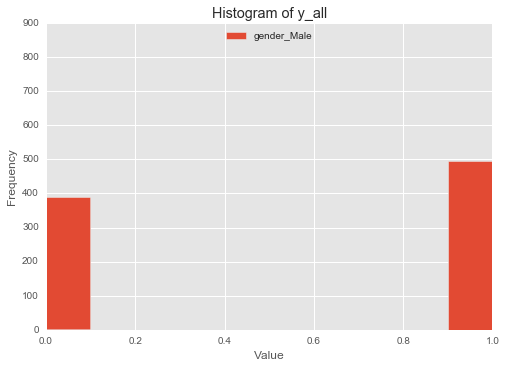

In [14]:
y.plot.hist()

_= pyplt.xlabel('Value')
_= pyplt.title('Histogram of y_all')
_= pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
_= pyplt.yticks(np.arange(0, 1000, 100))


In [15]:
## Make sure we drop the target from the table, otherwise we will be including the labeled data

print "Feature column(s):-", list(X)

Feature column(s):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


## Feature Transformation
We will use principal component analysis (PCA) to draw conclusions about the underlying structure of the data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe students.

In [16]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca_data = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

pca = PCA(n_components=3)
pca.fit(pca_data)

# Generate PCA results plot
pca_results = tools.pca_results(pca_data, pca)

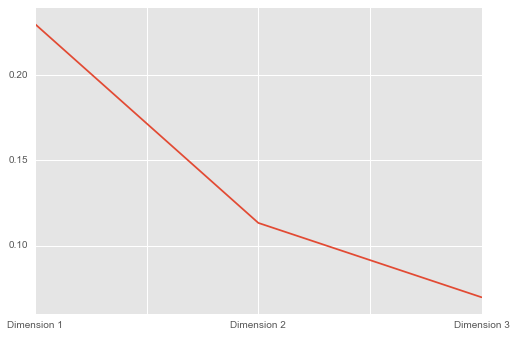

In [17]:
pca_results['Explained Variance'].plot();

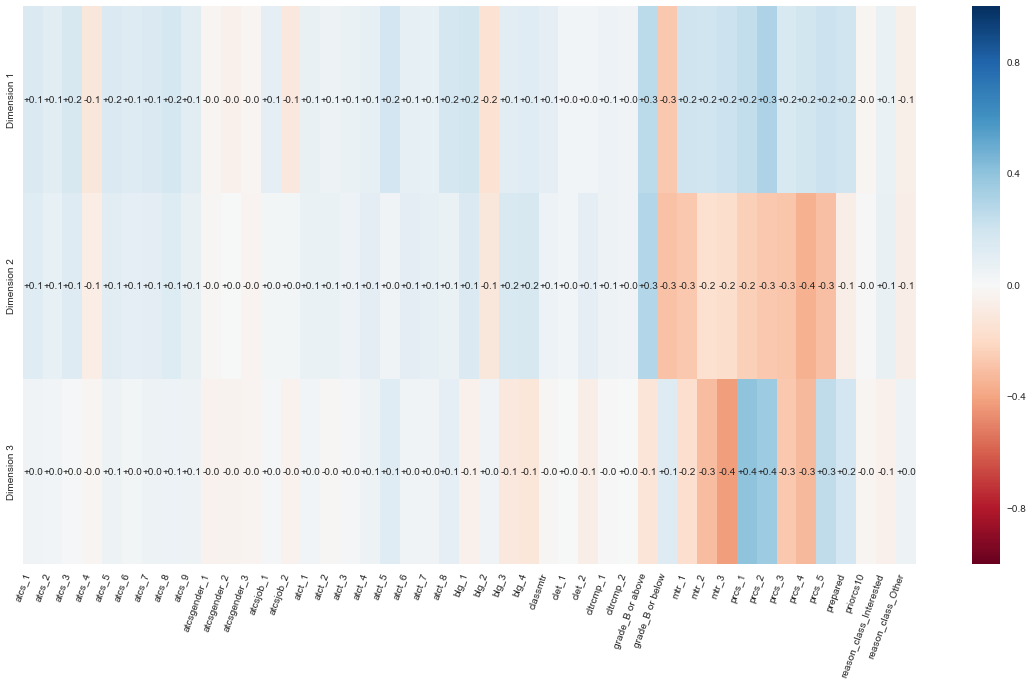

In [18]:
cols = [col for col in pca_results.columns if col not in ['Explained Variance']]
df2 = pca_results[cols]

myFileName='report/figures' + '/' + 'pcaStudentData' +'.png'
rcParams['figure.figsize'] = 20, 10
fig = figure(dpi=80) # no frame

with sns.axes_style("white"):
    ax = sns.heatmap(df2, square=False, annot=True, vmin=-1, vmax=1, cmap='RdBu', fmt='+.1f')
    plt.xticks(rotation=70, ha='right');
    
fig.savefig(myFileName)

Unsurprisingly, dimensions 1 and 2 account for almost 50% of the variance in the data. One of the interesting aspects of PCA is that the most interesting dynamics occur only in the first *k* dimension, and then they fall off. In this case, I would say the first **2** components highlight some clear student segments.    

 

#### First Principal Component Analysis - Dimension 1

#### Second Principal Component Analysis - Dimension 2


In [19]:
from time import time


print("Projecting the input data on the eigenfaces orthonormal basis")
X_all_pca = pca.transform(X)

Projecting the input data on the eigenfaces orthonormal basis


In [20]:
X_all_pca = pd.DataFrame(X_all_pca)
X_all_pca.columns = ['pca_1', 'pca_2', 'pca_3']
X_all_pca.head()

,pca_1,pca_2,pca_3
0,-0.283988,0.602065,0.231407
1,-2.041676,-1.728263,-0.808885
2,0.702112,0.529915,-0.169924
3,0.303765,0.539674,0.212410
4,-0.916082,0.962346,0.136683


In [21]:

X_all = X
X_all['pca_1'] = X_all_pca['pca_1']
X_all['pca_2'] = X_all_pca['pca_2']
X_all['pca_3'] = X_all_pca['pca_3']

## Modeling and Validating

#### Dictionary of models to run



In [35]:
X = X.drop(['pca_1','pca_2','pca_3'], axis=1, inplace=False)
print "\nFeature values:-"
print X.head() 


Feature values:-
   atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
0     0.5    0.75    1.00    0.50    0.75    0.75    0.75    0.50    0.75   
1     0.0    0.00    0.00    1.00    0.00    0.00    0.00    0.00    0.25   
2     1.0    1.00    1.00    0.00    1.00    1.00    1.00    1.00    1.00   
3     1.0    0.75    0.75    0.00    0.75    0.75    0.75    1.00    1.00   
4     0.5    0.50    0.75    0.25    0.50    0.75    1.00    0.25    0.75   

   atcsgender_1         ...          mtr_3  prcs_1  prcs_2  prcs_3  prcs_4  \
0           0.0         ...            0.0     0.0     0.0     0.0     0.0   
1           0.0         ...            0.0     0.0     0.0     1.0     1.0   
2           0.0         ...            1.0     0.0     0.0     0.0     0.0   
3           0.0         ...            0.0     0.0     0.0     0.0     0.0   
4           0.0         ...            0.0     0.0     0.0     0.0     0.0   

   prcs_5  prepared  priorcs10  reason_class_Inter

In [36]:

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score


models = {
          'XGBoost': XGBClassifier()
         }


In [ ]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y, n_folds=50, random_state=7)
    results = cross_val_score(model, X, y, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'
    

XGBoost


In [25]:
model.fit(X, y)
g = xgb.to_graphviz(model)
g.render('report/figures/X_graph.gv', view=True)
    

'report/figures/X_graph.gv.pdf'

#### Generate Features from XGBoost classifier 

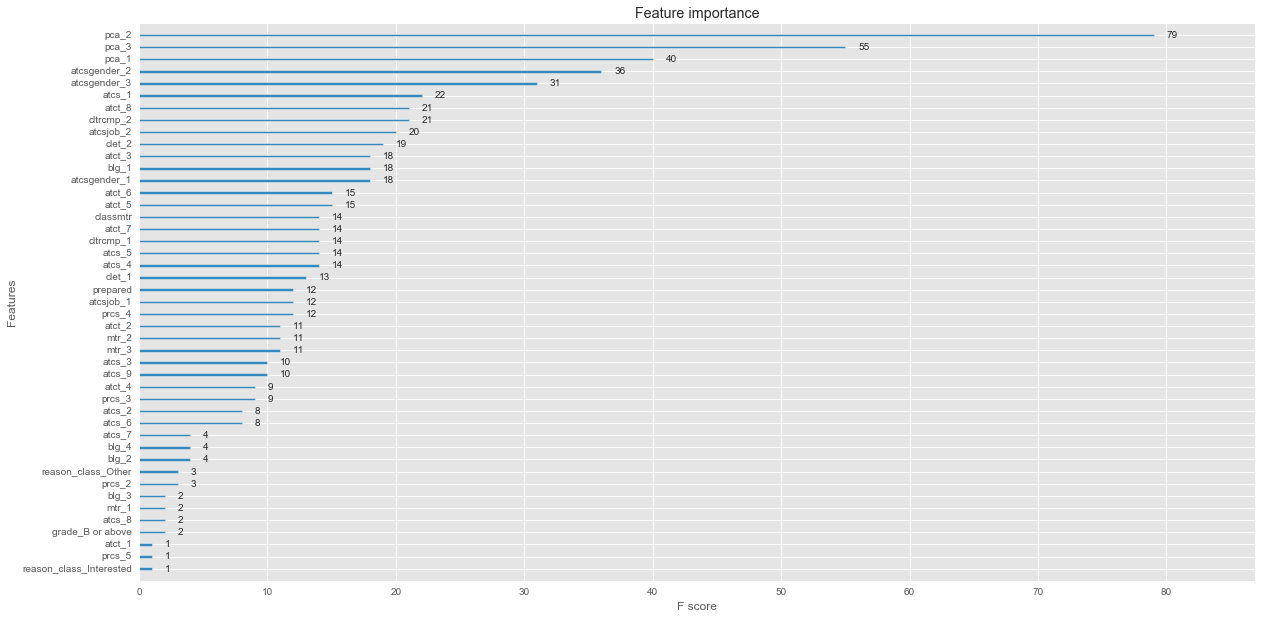

In [26]:
# plot feature importance
from xgboost import plot_importance


model.fit(X, y)
plot_importance(model)
pyplot.show()

### Use a reduced set of features

In [27]:
# Extract feature (X) and target (y) columns

target_col = dataset['gender_Male']  #  column is the target/label 

y_all = target_col  # corresponding targets/labels
X_all_Reduced = X_all[['pca_2', 'pca_3', 'pca_1', 
                'atcsgender_2', 'atcsgender_3', 
                'atcs_1', 'atcs_8',
                'cltrcmp_2', 'atcsjob_2', 'clet_2', 'atct_3',
                'blg_1', 'atcsgender_1']]


print "\nFeature values:-"
print X_all_Reduced.head()  
print y_all.head()


Feature values:-
      pca_2     pca_3     pca_1  atcsgender_2  atcsgender_3  atcs_1  atcs_8  \
0  0.602065  0.231407 -0.283988          0.50          0.50     0.5    0.50   
1 -1.728263 -0.808885 -2.041676          0.00          0.25     0.0    0.00   
2  0.529915 -0.169924  0.702112          0.50          0.50     1.0    1.00   
3  0.539674  0.212410  0.303765          0.50          0.00     1.0    1.00   
4  0.962346  0.136683 -0.916082          0.75          0.00     0.5    0.25   

   cltrcmp_2  atcsjob_2  clet_2  atct_3  blg_1  atcsgender_1  
0       0.75       0.25     0.5    0.75   0.75           0.0  
1       1.00       0.50     0.5    0.50   0.25           0.0  
2       1.00       0.50     0.5    1.00   0.50           0.0  
3       1.00       0.25     1.0    1.00   0.50           0.0  
4       1.00       0.25     1.0    1.00   0.75           0.0  
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: gender_Male, dtype: float64


In [28]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_all, n_folds=50, random_state=7)
    results = cross_val_score(model, X_all_Reduced, y_all, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'



XGBoost
Accuracy: 67.40% (11.67%) 



In [29]:
model.fit(X_all_Reduced, y_all)
g = xgb.to_graphviz(model)
g.render('report/figures/X_all_Reduced_graph.gv', view=True)

'report/figures/X_all_Reduced_graph.gv.pdf'

In [30]:
X_all_No_Gender = X_all.drop(['pca_1','pca_2','pca_3','atcsgender_1','atcsgender_2','atcsgender_3',], 
                            axis=1, inplace=False)


print "\nFeature values:-"
print X_all_No_Gender.head()  


Feature values:-
   atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
0     0.5    0.75    1.00    0.50    0.75    0.75    0.75    0.50    0.75   
1     0.0    0.00    0.00    1.00    0.00    0.00    0.00    0.00    0.25   
2     1.0    1.00    1.00    0.00    1.00    1.00    1.00    1.00    1.00   
3     1.0    0.75    0.75    0.00    0.75    0.75    0.75    1.00    1.00   
4     0.5    0.50    0.75    0.25    0.50    0.75    1.00    0.25    0.75   

   atcsjob_1         ...          mtr_3  prcs_1  prcs_2  prcs_3  prcs_4  \
0       0.75         ...            0.0     0.0     0.0     0.0     0.0   
1       0.00         ...            0.0     0.0     0.0     1.0     1.0   
2       1.00         ...            1.0     0.0     0.0     0.0     0.0   
3       1.00         ...            0.0     0.0     0.0     0.0     0.0   
4       1.00         ...            0.0     0.0     0.0     0.0     0.0   

   prcs_5  prepared  priorcs10  reason_class_Interested  reason_clas

In [31]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_all, n_folds=50, random_state=7)
    results = cross_val_score(model, X_all_No_Gender, y_all, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'


XGBoost
Accuracy: 67.47% (10.94%) 



In [32]:
model.fit(X_all_No_Gender, y_all)
g = xgb.to_graphviz(model)
g.render('report/figures/X_all_No_Gender_graph.gv', view=True)

'report/figures/X_all_No_Gender_graph.gv.pdf'